In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [6]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01,  9.60it/s]


(631304, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [7]:
def land_shape2(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if '사다리' in x:
            return '사다리형'
        elif '장방' in x:
            return '장방형'
        elif '정방' in x:
            return '정방형'
        elif '부정' in x:
            return '부정형'
        elif '않음' in x:
            return '지정되지않음'
        elif '자루' in x:
            return '자루형'
        elif '삼각' in x:
            return '삼각형'
        else:
            return '기타'

In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
land_specs_df['지형형상2'] = land_specs_df['지형형상'].apply(land_shape2)
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 12)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가,지형형상2
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0,부정형
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0,부정형
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0,부정형
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0,부정형
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0,부정형


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 10)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,부정형
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지,부정형
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지,부정형


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [11]:
print(house_merge_df.shape)

(628777, 21)


In [12]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [13]:
target_gu = '관악구'
target_dong = '봉천동'
#target_purpose = '준공업'
target_building_age = 5
target_period = 18 # in months

In [14]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(205, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
63359,서울특별시 관악구 봉천동 196-310,낙성대역6길 14,에이원빌,44.14,26.32,38000,1,2016.0,4.0,2020-01-03,860.897145,5.0,대,1044.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),정방형,관악구,봉천동
63360,서울특별시 관악구 봉천동 196-310,낙성대역6길 14,에이원빌,47.01,28.03,39200,2,2016.0,4.0,2020-03-11,833.865135,5.0,대,1044.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),정방형,관악구,봉천동
63361,서울특별시 관악구 봉천동 196-310,낙성대역6길 14,에이원빌,39.71,23.68,36200,5,2016.0,4.0,2020-06-18,911.609166,5.0,대,1044.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),정방형,관악구,봉천동
63362,서울특별시 관악구 봉천동 196-310,낙성대역6길 14,에이원빌,40.55,24.18,35000,1,2016.0,4.0,2020-12-02,863.131936,5.0,대,1044.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),정방형,관악구,봉천동
64429,서울특별시 관악구 봉천동 649-191,봉천로21나길 4,한성파크빌리지,55.14,34.05,31000,4,2018.0,1.0,2019-12-06,562.205296,3.0,대,1706.0,제2종일반주거지역,지정되지않음,다세대,완경사,부정형,소로한면,부정형,관악구,봉천동


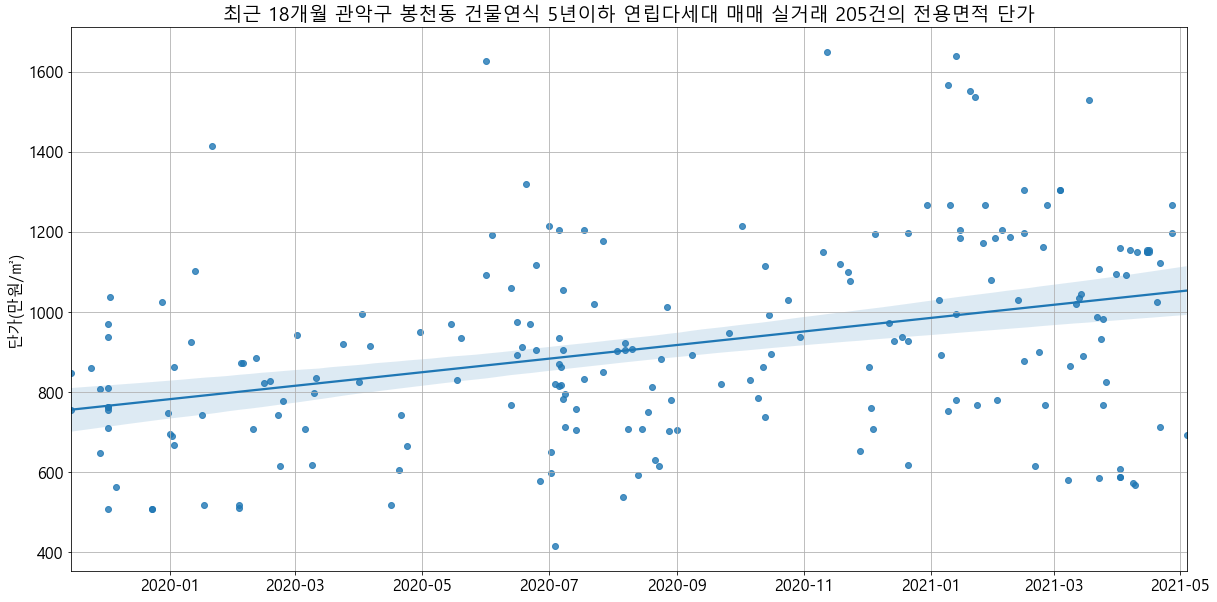

In [15]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house))

In [48]:
concat_df = pd.concat([target_df])

In [49]:
concat_df.head()

,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
63359,서울특별시 관악구 봉천동 196-310,낙성대역6길 14,에이원빌,44.14,26.32,38000,1,2016.0,4.0,2020-01-03,860.897145,5.0,대,1044.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),정방형,관악구,봉천동
63360,서울특별시 관악구 봉천동 196-310,낙성대역6길 14,에이원빌,47.01,28.03,39200,2,2016.0,4.0,2020-03-11,833.865135,5.0,대,1044.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),정방형,관악구,봉천동
63361,서울특별시 관악구 봉천동 196-310,낙성대역6길 14,에이원빌,39.71,23.68,36200,5,2016.0,4.0,2020-06-18,911.609166,5.0,대,1044.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),정방형,관악구,봉천동
63362,서울특별시 관악구 봉천동 196-310,낙성대역6길 14,에이원빌,40.55,24.18,35000,1,2016.0,4.0,2020-12-02,863.131936,5.0,대,1044.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),정방형,관악구,봉천동
64429,서울특별시 관악구 봉천동 649-191,봉천로21나길 4,한성파크빌리지,55.14,34.05,31000,4,2018.0,1.0,2019-12-06,562.205296,3.0,대,1706.0,제2종일반주거지역,지정되지않음,다세대,완경사,부정형,소로한면,부정형,관악구,봉천동


In [50]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [51]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(205, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동,단가평균
0,서울특별시 관악구 봉천동 100-30,행운9길 29,리벤하임,27.16,15.79,26500,2,2017.0,3.0,2020-06-16,975.699558,4.0,대,169.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,소로각지,장방형,관악구,봉천동,841.081853
1,서울특별시 관악구 봉천동 100-30,행운9길 29,리벤하임,28.31,16.48,20000,4,2017.0,3.0,2020-08-15,706.464147,4.0,대,169.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,소로각지,장방형,관악구,봉천동,841.081853
2,서울특별시 관악구 봉천동 100-66,행운5길 32-10,비쥬타운2차,29.89,19.59,28000,3,2016.0,4.0,2020-10-30,936.768150,5.0,대,99.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),장방형,관악구,봉천동,936.768150
3,서울특별시 관악구 봉천동 100-66,행운5길 32-10,비쥬타운2차,29.89,19.59,28000,2,2016.0,4.0,2020-12-18,936.768150,5.0,대,99.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),장방형,관악구,봉천동,936.768150
4,서울특별시 관악구 봉천동 100-70,행운5길 32-5,스타,23.47,23.00,28000,4,2018.0,2.0,2020-06-04,1193.012356,3.0,대,212.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),장방형,관악구,봉천동,949.679801


In [52]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(73, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동,단가평균
1,서울특별시 관악구 봉천동 100-30,행운9길 29,리벤하임,28.310,16.48,20000,4,2017.0,3.0,2020-08-15,706.464147,4.0,대,169.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,소로각지,장방형,관악구,봉천동,841.081853
3,서울특별시 관악구 봉천동 100-66,행운5길 32-10,비쥬타운2차,29.890,19.59,28000,2,2016.0,4.0,2020-12-18,936.768150,5.0,대,99.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),장방형,관악구,봉천동,936.768150
5,서울특별시 관악구 봉천동 100-70,행운5길 32-5,스타,40.490,27.25,28600,2,2018.0,2.0,2020-08-08,706.347246,3.0,대,212.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),장방형,관악구,봉천동,949.679801
7,서울특별시 관악구 봉천동 100-81,행운5길 29,우리빌타운 3차,26.250,16.95,27000,5,2016.0,4.0,2020-10-24,1028.571429,5.0,대,102.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로각지(가),장방형,관악구,봉천동,985.272903
9,서울특별시 관악구 봉천동 100-84,행운5길 31-3,비쥬타운B,26.540,16.71,28000,5,2016.0,4.0,2020-07-08,1055.011304,5.0,대,109.0,제2종일반주거지역,지정되지않음,단독,완경사,세로장방,세로한면(가),장방형,관악구,봉천동,963.013435
11,서울특별시 관악구 봉천동 100-89,행운5길 31-5,비쥬타운C,28.470,17.67,24200,2,2016.0,4.0,2020-07-27,850.017562,5.0,대,96.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),장방형,관악구,봉천동,899.192132
12,서울특별시 관악구 봉천동 100-90,행운5길 31-9,리인아트빌,23.810,17.53,26000,5,2016.0,4.0,2020-06-01,1091.978160,5.0,대,116.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),장방형,관악구,봉천동,1091.978160
14,서울특별시 관악구 봉천동 1511-3,봉천로17길 55-5,송암하이츠빌라,29.520,23.26,25900,3,2016.0,5.0,2021-02-15,877.371274,5.0,대,256.1,제1종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),장방형,관악구,봉천동,810.267088
25,서울특별시 관악구 봉천동 1515-4,양녕로6다길 26,아크로팰리스,28.240,18.39,35800,2,2020.0,1.0,2021-04-27,1267.705382,1.0,대,281.3,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),정방형,관악구,봉천동,1258.168054
26,서울특별시 관악구 봉천동 1524-39,장군봉4길 3,필하우스2차 101동,42.410,26.38,37500,2,2016.0,4.0,2020-02-11,884.225419,5.0,대,214.5,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),장방형,관악구,봉천동,884.225419


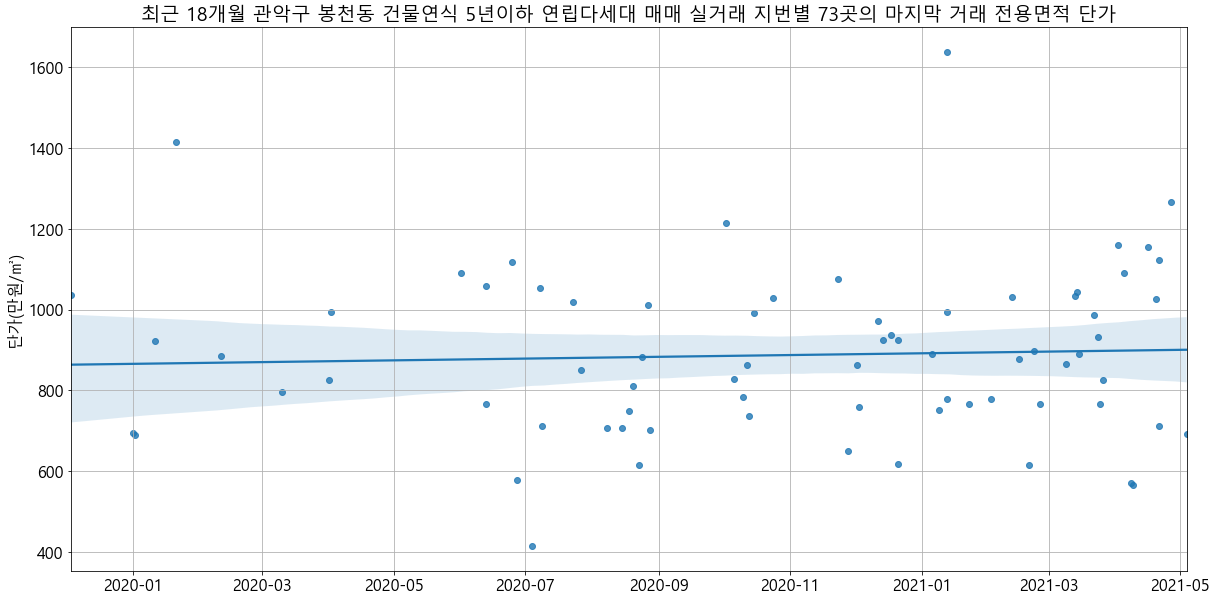

In [53]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(concat_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(concat_last_df['계약날짜']), y=concat_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_산포도.png'.format(target_gu, target_dong, target_house))

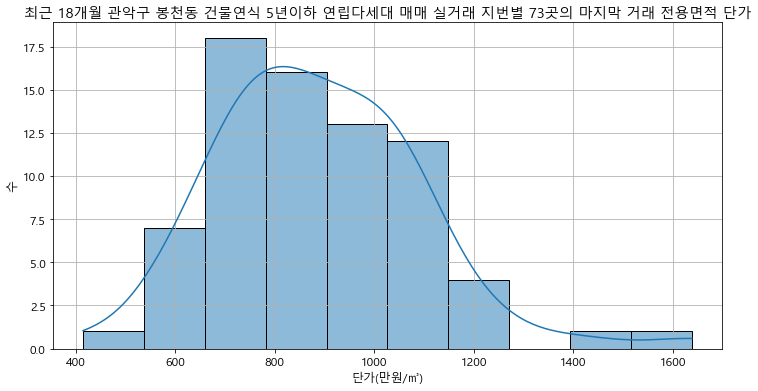

<Figure size 432x288 with 0 Axes>

In [54]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.grid(True)
plt.ylabel('수')
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
sns.histplot(concat_last_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house))
plt.show()
plt.clf()

In [43]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [55]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가(만원/㎡)', '용도지역명1']]
concat_last_df

,지번주소,건물(단지)명,건축년도,계약날짜,단가(만원/㎡),용도지역명1
1,서울특별시 관악구 봉천동 100-30,리벤하임,2017.0,2020-08-15,706.464147,제2종일반주거지역
3,서울특별시 관악구 봉천동 100-66,비쥬타운2차,2016.0,2020-12-18,936.768150,제2종일반주거지역
5,서울특별시 관악구 봉천동 100-70,스타,2018.0,2020-08-08,706.347246,제2종일반주거지역
7,서울특별시 관악구 봉천동 100-81,우리빌타운 3차,2016.0,2020-10-24,1028.571429,제2종일반주거지역
9,서울특별시 관악구 봉천동 100-84,비쥬타운B,2016.0,2020-07-08,1055.011304,제2종일반주거지역
11,서울특별시 관악구 봉천동 100-89,비쥬타운C,2016.0,2020-07-27,850.017562,제2종일반주거지역
12,서울특별시 관악구 봉천동 100-90,리인아트빌,2016.0,2020-06-01,1091.978160,제2종일반주거지역
14,서울특별시 관악구 봉천동 1511-3,송암하이츠빌라,2016.0,2021-02-15,877.371274,제1종일반주거지역
25,서울특별시 관악구 봉천동 1515-4,아크로팰리스,2020.0,2021-04-27,1267.705382,제2종일반주거지역
26,서울특별시 관악구 봉천동 1524-39,필하우스2차 101동,2016.0,2020-02-11,884.225419,제2종일반주거지역


In [56]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house), index=False)